In [153]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial as spatial
import shapely.geometry as shpg
import cv2
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20c.colors)

In [154]:
ext_array = np.load('/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/04_OUTPUT/C0002233/C0002233_int_CORT_ext_0.npy')
int_array = np.load('/home/simoneponcioni/Documents/01_PHD/03_Methods/Meshing/Meshing/04_OUTPUT/C0002233/C0002233_int_CORT_int_0.npy')
# ext_array = ext_array[:-1]
# int_array = int_array[:-1]

In [155]:
def offset_surface(ext_line, offset):
    '''
    Create artificial internal surface based on an offset
    Don't implement in main script it's just for testing
    '''
    # Create a Polygon from the 2d array
    poly = shpg.Polygon(ext_line)

    # Create offset in inward direction
    noffpoly = poly.buffer(offset)  # offset

    # Turn polygon points into numpy arrays for plotting
    afpolypts = np.array(poly.exterior)
    noffafpolypts = np.array(noffpoly.exterior)
    return noffafpolypts

(100, 2)
(100, 2)


/tmp/ipykernel_65919/598898864.py:5: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ext_offset = offset_surface(ext_array, -1)


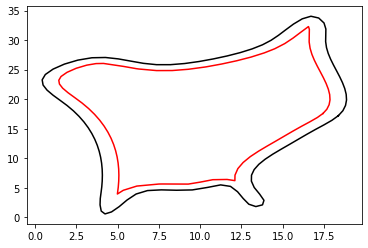

In [157]:
# TEST IF POINT INSIDE POLYGON
# https://stackoverflow.com/questions/50670326/how-to-check-if-point-is-placed-inside-contour


ext_offset = offset_surface(ext_array, -1)

# is_inside = shpg.Point(0, 0).within(shpg.Polygon(ext_offset))
is_inside = [shpg.Point(int_array[i]).within(shpg.Polygon(ext_offset)) for i in range(len(int_array))]
is_inside = np.c_[is_inside, is_inside]
closest_points = [ext_offset[spatial.KDTree(ext_offset).query(int_array[i])[1]] for i in range(len(int_array))]
closest_points = np.array(closest_points).reshape(-1, 2)
print(int_array.shape)
print(closest_points.shape)

np.copyto(dst=int_array, src=closest_points, where=np.logical_not(is_inside))

plt.plot(ext_array[:, 0], ext_array[:, 1], 'k')
plt.plot(int_array[:, 0], int_array[:, 1], 'r')

/tmp/ipykernel_65919/2831731045.py:71: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  ext_offset = offset_surface(ext_array, -0.1)


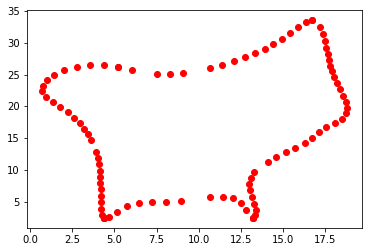

In [118]:

def correct_internal_point(arr, idx, dx, dy):
    """
    Corrects [x, y] position of points of internal array
    Args:
        arr (ndarray): array of internal perimeter
        dx (float): normal component x * minimum thickness
        dy (float): normal component y * minimum thickness
    Returns:
        ndarray: new position of internal points in array 'arr'
    """
    return np.array([arr[idx][:, 0] - dy, arr[idx][:, 1] + dx]).transpose()

def correct_intersection(ext_arr, int_arr, pairs, dx, dy, bool_arr):
    """
    Takes ext and int arrays and applies nodal displacement to the elements where bool_min_thickness == True
    Args:
        ext_arr (ndarray): array of [x, y] external points composing the perimeter
        int_arr (ndarray): array of [x, y] internal points composing the perimeter
        dx (float): normal component x * minimum thickness
        dy (float): normal component y * minimum thickness
        bool_min_thickness (list): list indicating where the thickness is below tolerance
    Returns:
        ndarray: new array of internal polygon
    """
    bool_arr = np.c_[bool_arr, bool_arr]
    int_corr = correct_internal_point(ext_arr, pairs[0], dx, dy)
    np.copyto(dst=int_arr[pairs[1]], src=int_corr, where=bool_arr)
    return int_arr


def KD_2_Tree(arr1, arr2, ext_offset):
    """
    Find nearest point between two arrays and create a an array containing nearest-pairs indices
    
    Args:
        arr1 (np.ndarray): array of contour 1
        arr2 (np.ndarray): array of contour 2
        
    Returns:
        _type_: _description_
    """
    corr_int = np.empty((len(arr1), 2), dtype=float)
    for i, idx in enumerate(arr1):
        d_nn_ext_int, closest_idx_ext_int = spatial.KDTree(arr2).query(idx)
        d_nn_ext_offs, closest_idx_ext_offs = spatial.KDTree(ext_offset).query(idx)       
        
        if d_nn_ext_int > d_nn_ext_offs:
            corr_int[i] = arr2[closest_idx_ext_int]
        elif d_nn_ext_int < d_nn_ext_offs:
            corr_int[i] = ext_offset[closest_idx_ext_offs]
    return corr_int


ext_offset = offset_surface(ext_array, -0.1)
corr_int = KD_2_Tree(ext_array, int_array, ext_offset)
plt.plot(corr_int[:, 0], corr_int[:, 1], 'o', color='red')

In [83]:
# find the two closest points for i in enumerate(arr1)
